In [2]:
from nerfstudio.pipelines.imaginedriving_pipeline import ImagineDrivingPipelineConfig, ImagineDrivingPipeline
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig, ADDataManager
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.models.neurad import NeuRADModelConfig

In [3]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/s0001900/dev/neurad-studio


In [4]:
from dataclasses import asdict

config = ImagineDrivingPipelineConfig(
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True),
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
    ),
)
asdict(config)

{'_target': nerfstudio.pipelines.imaginedriving_pipeline.ImagineDrivingPipeline,
 'datamanager': {'_target': nerfstudio.data.datamanagers.ad_datamanager.ADDataManager,
  'data': None,
  'masks_on_gpu': False,
  'images_on_gpu': False,
  'dataparser': {'_target': nerfstudio.data.dataparsers.pandaset_dataparser.PandaSet,
   'data': PosixPath('data/pandaset'),
   'sequence': '001',
   'train_split_fraction': 0.5,
   'train_eval_split_type': <SplitTypes.LINSPACE: 'linspace'>,
   'max_eval_frames': None,
   'dataset_start_fraction': 0.0,
   'dataset_end_fraction': 1.0,
   'cameras': ('front', 'front_left', 'front_right', 'back', 'left', 'right'),
   'lidars': ('Pandar64',),
   'min_lidar_dist': (1.0, 2.0, 2.0),
   'radars': (),
   'load_cuboids': True,
   'include_deformable_actors': False,
   'annotation_interval': 0.1,
   'rolling_shutter_offsets': (-0.03, 0.01),
   'allow_per_point_times': True,
   'add_missing_points': True,
   'lidar_elevation_mapping': {'Pandar64': {0: 14.882,
     1:

In [5]:
pipe = ImagineDrivingPipeline(config, device='cuda')

Variable resolution, using variable_res_collate

Output()

Output()

Setting up evaluation dataset...

Caching all 240 images.

Output()

Caching all 40 images.

Output()

WARNING: Using a slow implementation for the NeuRAD module. 

🏃 🏃 Install tcnn for speedups 🏃 🏃

pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

4D hashgrid is not supported with torch implementation, falling back multiple grids.

4D hashgrid is not supported with torch implementation, falling back multiple grids.

4D hashgrid is not supported with torch implementation, falling back multiple grids.

/home/s0001900/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s0001900/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/s0001900/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
pipe.datamanager

ADDataManager(
  (train_lidar_ray_generator): LidarRayGenerator()
  (eval_ray_generator): RayGenerator()
  (eval_lidar_ray_generator): LidarRayGenerator()
)

In [7]:
ray_bundle, batch = pipe.datamanager.next_train(0)

In [8]:
batch["img_indices"]

tensor([[  11,  629, 1123],
        [  11,  629, 1126],
        [  11,  629, 1129],
        ...,
        [ 235,  861,  205],
        [ 235,  861,  208],
        [ 235,  861,  211]], device='cuda:0')

In [34]:
ray_bundle.origins.shape

torch.Size([57344, 3])

In [18]:
import matplotlib.pyplot as plt

In [42]:
is_cam = ~ray_bundle.metadata["is_lidar"].flatten()

In [40]:
is_cam.shape

torch.Size([57344, 1])

In [39]:
is_cam.repeat(1, 3).shape

torch.Size([57344, 3])

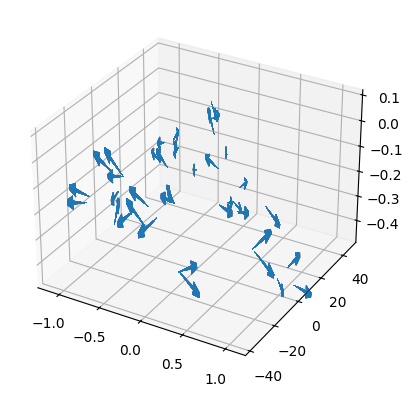

In [43]:

orig = ray_bundle.origins[is_cam].cpu()
dirs = ray_bundle.directions[is_cam].cpu()

fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()
ax.quiver(
    orig[:, 0],
    orig[:, 1],
    orig[:, 2],
    dirs[:, 0],
    dirs[:, 1],
    dirs[:, 2],
    length=0.25,
    linewidths=0.01
)

plt.show()

Cameras(camera_to_worlds=tensor([[[ 9.9838e-01,  3.5480e-02, -4.4465e-02, -4.5069e-01],
         [-4.4310e-02, -5.1333e-03, -9.9900e-01, -3.8818e+01],
         [-3.5673e-02,  9.9936e-01, -3.5529e-03, -2.5725e-02]],

        [[ 9.9888e-01,  2.4555e-02, -4.0441e-02, -4.0370e-01],
         [-4.0135e-02, -1.2860e-02, -9.9911e-01, -3.7267e+01],
         [-2.5054e-02,  9.9962e-01, -1.1860e-02, -8.1896e-03]],

        [[ 9.9906e-01,  2.2569e-02, -3.6967e-02, -3.4305e-01],
         [-3.6500e-02, -2.0767e-02, -9.9912e-01, -3.5666e+01],
         [-2.3316e-02,  9.9953e-01, -1.9924e-02, -3.7483e-03]],

        ...,

        [[ 3.7832e-02,  3.9673e-02, -9.9850e-01,  2.6084e-01],
         [-9.9925e-01, -6.4561e-03, -3.8117e-02,  3.9204e+01],
         [-7.9586e-03,  9.9919e-01,  3.9399e-02, -3.4414e-01]],

        [[ 2.9495e-02,  4.0081e-02, -9.9876e-01,  2.3644e-01],
         [-9.9956e-01, -2.6073e-03, -2.9623e-02,  4.1754e+01],
         [-3.7914e-03,  9.9919e-01,  3.9986e-02, -3.2586e-01]],

      

In [67]:
# 90 degree shift should reflect on image

cam_to_worlds = pipe.datamanager.train_dataset.cameras.camera_to_worlds[ray_bundle.camera_indices[is_cam].flatten().cpu()]

In [71]:
import torch

In [94]:
def rot_pitch(theta):
    theta = torch.tensor(theta)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    return torch.tensor([[cos_theta, 0, sin_theta], [0, 1, 0], [-sin_theta, 0, cos_theta]])

rot_pitch(torch.pi/2)

tensor([[-4.3711e-08,  0.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
        [-1.0000e+00,  0.0000e+00, -4.3711e-08]])

In [96]:
def make_cam_matrix(rotation, translation):
    return torch.cat((rotation, translation[..., None]), dim=-1)[None, ...]

In [95]:
unit_cam = make_cam_matrix(torch.eye(3), torch.zeros(3))
unit_cam

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

In [114]:
translate = torch.tensor([[1, 0, 0, 0]]).float().T
#cam_to_worlds[:, :3] @ translate 
#unit_cam @ translate 
#rot_pitch(torch.pi/2) @ translate 
theta = torch.pi / 4
flip_cam = make_cam_matrix(rot_pitch(theta), torch.zeros(3))
flip_cam @ translate

tensor([[[ 0.7071],
         [ 0.0000],
         [-0.7071]]])

In [166]:
v1 = torch.tensor([1, 0, 0, 0]).float().T

vs = []

n_vs = 8
for i in range(n_vs):
    theta = 2 * i * torch.pi / n_vs 
    flip_cam = make_cam_matrix(rot_pitch(theta), torch.zeros(3))
    v = (flip_cam @ v1).flatten()
    vs.append(v)

dirs = torch.stack(vs)
origs = torch.zeros_like(dirs)

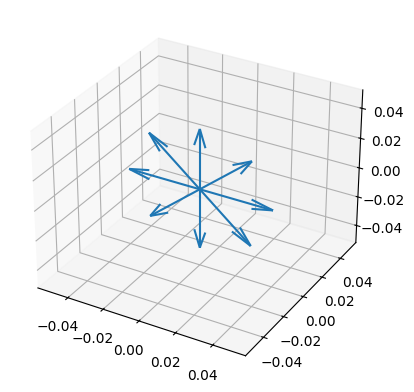

In [167]:
fig = plt.figure()
fig.add_subplot(projection='3d')
ax = fig.gca()

ax.quiver(
    origs[:, 0],
    origs[:, 1],
    origs[:, 2],
    dirs[:, 0], 
    dirs[:, 1],
    dirs[:, 2],
    normalize=False,
    length=0.04,
)